# Models of Neurons

## Euler method: the leaky neuron

We first consider the equation:
$	C_m \dfrac{d V_m}{d t} = - g_l (V_m - E_l)$

We are going to simulate this equation with the Euler method.

In [27]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 7)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

title_fontsize = 36
ax_fontsize = 28
label_fontsize = 20

Cm = 100e-12  # in F
gl = 10e-9    # in S
El = -70e-3   # in V
taum = Cm/gl  # in s

In [53]:
def leaky_neuron(t,dt,I,V0,spike=False):
    # Numerical simulation of a LIF neuron
    N = int(t/dt)+1
    V = V0*np.ones(N)
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I[i]/Cm
        V[i] = V[i-1] + dt*updt_V
    return V

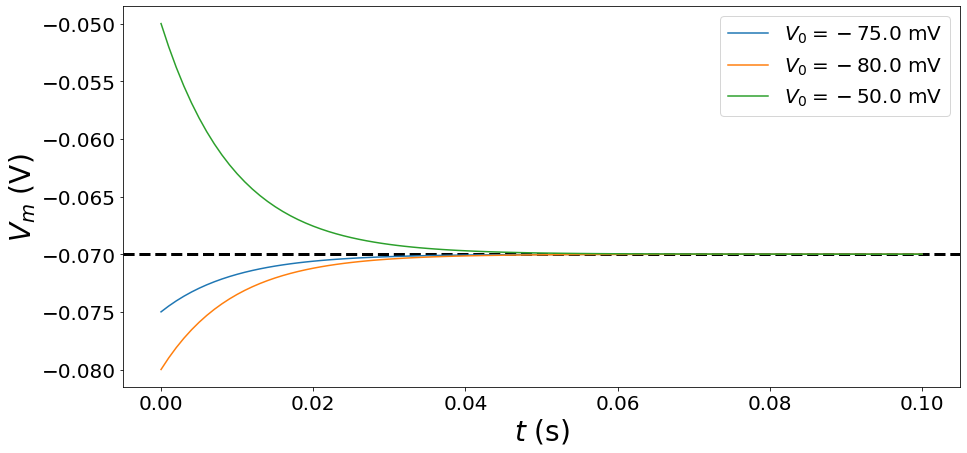

In [54]:
dt = .001 # in s
t = .1    # in s
I = np.zeros(int(t/dt)+1)

plt.axhline(El, color='k', ls='--', lw=3)
for V0 in [-75.0,-80.0,-50.0]: # in mV
    V = leaky_neuron(t,dt,I,V0*.001)
    plt.plot(np.linspace(0,t,int(t/dt)+1),V,label=r"$V_0 = "+str(V0)+"$ mV")
plt.xlabel(r"$t$ (s)", fontsize=ax_fontsize)
plt.ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
plt.legend(fontsize=label_fontsize)
plt.show()

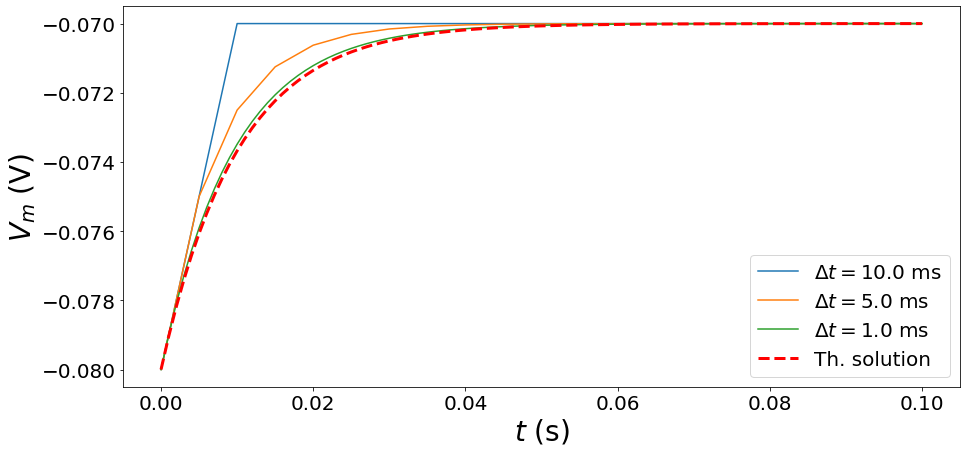

In [55]:
# We are going to look at the influence of dt
t = .1      # in s
V0 = -80e-3 # in V

for dt in [10.0e-3,5.0e-3,1.0e-3]:
    I = np.zeros(int(t/dt)+1)
    V = leaky_neuron(t,dt,I,V0)
    plt.plot(np.linspace(0,t,int(t/dt)+1),V,label=r"$\Delta t = "+str(dt*1e3)+"$ ms")

def sol(t):
    return El + (V0-El)*np.exp(-t/taum)

time_abs = np.linspace(0,t,int(t/dt)+1)
plt.plot(time_abs,sol(time_abs),"r--",lw=3,label="Th. solution")
plt.xlabel(r"$t$ (s)", fontsize=ax_fontsize)
plt.ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
plt.legend(fontsize=label_fontsize)
plt.show()

## LIF neuron

We now consider the equation of the LIF model, thus with the emission of a spike. 

\begin{align}
	&C_m \dfrac{d V_m}{d t}  =g_L (E_L - V_m) + I_{app}\\
	&\text{if $V_m > V_{th}$ , then $V_m =V_{reset}$}
\end{align}

In [56]:
def LIF_neuron(t,dt,I,V0,spike=False):
    # Numerical simulation of a LIF neuron
    N = int(t/dt)+1
    V = V0*np.ones(N)
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I[i]/Cm
        V[i] = V[i-1] + dt*updt_V
        if spike and V[i] > Vth:
            V[i] = Vreset
    return V

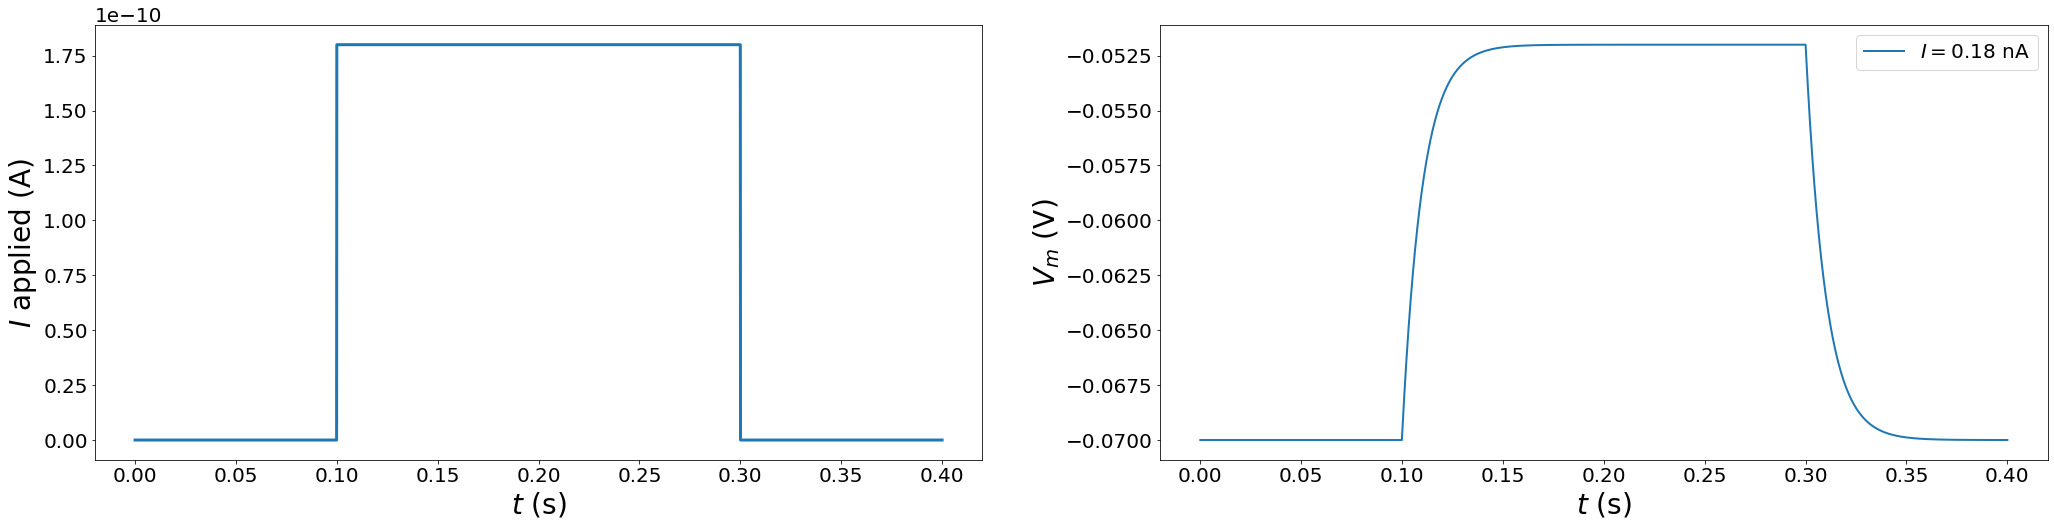

In [109]:
Vth = -50.0e-3    # V
Vreset = -80.0e-3 # V
V0 = -70.0e-3     # V
# with these conditions taum = 10ms and Ith = 200 pA

dt = .0001
t = .4
time_abs = np.linspace(0,t,int(t/dt)+1)

def step_I(I0, time_abs=time_abs, t_min=.1, t_max=.3):
    I = I0*np.ones(int(t/dt)+1)
    I[time_abs<t_min] = 0
    I[time_abs>t_max] = 0
    return I

fig, axes = plt.subplots(1,2,figsize=(35,8))

I0s = [.18e-9]
# I0s = [.21e-9]
# I0s = [.25e-9]
# I0s = [.18e-9, .21e-9, .25e-9]
for I0 in I0s:
    I = step_I(I0=I0)
    V = LIF_neuron(t,dt,I,V0,True)
    axes[0].plot(time_abs,I,lw=3)
    axes[0].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
    axes[0].set_ylabel(r"$I$ applied (A)", fontsize=ax_fontsize)
    axes[1].plot(time_abs,V,lw=2,label=r"$I = "+str(I0*1e9)+"$ nA")
    axes[1].set_xlabel(r"$t$ (s)", fontsize=ax_fontsize)
    axes[1].set_ylabel(r"$V_m$ (V)", fontsize=ax_fontsize)
    axes[1].legend(fontsize=label_fontsize)
plt.show()

As we can observe the limit current to obtain spikes is the one obtained analytically.

## Parenthesis: stiff equation

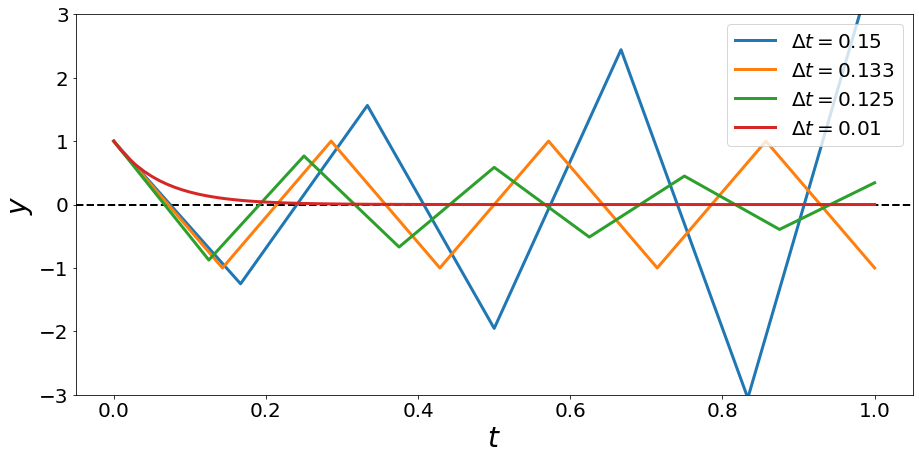

In [83]:
def exp_euler(dt,t,y0):
    N = int(t/dt)+1
    sol = y0*np.ones(N)
    for i in range(1,N):
        sol[i] = sol[i-1] -15*dt*sol[i-1]      
    return sol

t = 1
plt.axhline(0, color='k', ls='--', lw=2)
for dt in [0.15,2/15,0.125,0.01]:
    sol = exp_euler(dt,t,1.)
    plt.plot(np.linspace(0,t,int(t/dt)+1),sol,label=r"$\Delta t = "+str(np.round(dt,3))+"$", lw=3)
plt.ylim((-3,3))
plt.xlabel(r"$t$", fontsize=ax_fontsize)
plt.ylabel(r"$y$", fontsize=ax_fontsize)
plt.legend(fontsize=label_fontsize)
plt.show()

## LIF neuron f-I curve

We are now going to focus on the f-I curve of the neuron. We consider a LIF neuron, with the same parameters as previously.

In [84]:
def LIFneuronFR(t,dt,I,V0):
    # Numerical simulation of a LIF neuron with firing rate computation
    N = int(t/dt)+1
    V = V0*np.ones(N)
    spike_count = 0
    for i in range(1,N):
        updt_V = -(V[i-1] - El)/taum + I[i]/Cm
        V[i] = V[i-1] + dt*updt_V
        if V[i] > Vth:
            V[i] = Vreset
            spike_count += 1
    return V, spike_count/t

In [113]:
Vth = -50.0e-3
Vreset = -80.0e-3
V0 = El

dt = .001
t = 3
time_abs = np.linspace(0,t,int(t/dt)+1)


Iapp = np.arange(0,500) # in pA
FRs = np.zeros(len(Iapp))

for i in range(len(Iapp)):
    I0 = Iapp[i]
    I = I0*1e-12*np.ones(int(t/dt)+1)
    V, FR = LIFneuronFR(t,dt,I,V0)
    FRs[i] = FR

In [114]:
def th_fI(Is):
    th_FRs = np.zeros(len(Is))
    for i in range(len(Is)):
        I = Is[i]
        if I/gl + El - Vth > 0:
            t = taum*np.log(I/gl + El - Vreset) - taum*np.log(I/gl + El - Vth)
            th_FRs[i] = 1/t
        else:
            th_FRs[i] = 0
    return th_FRs

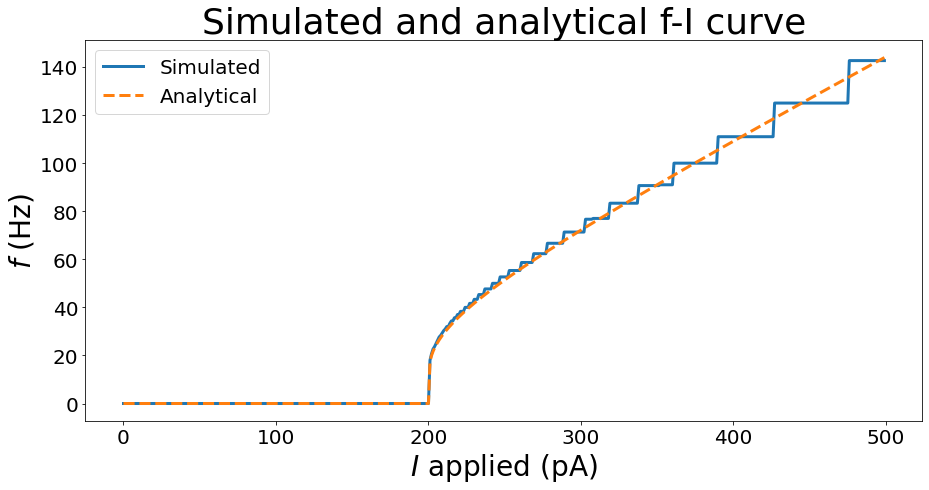

In [116]:
plt.plot(Iapp,FRs,lw=3,label="Simulated")
plt.plot(Iapp,th_fI(Iapp*1e-12),"--",lw=3,label="Analytical")
plt.xlabel(r"$I$ applied (pA)", fontsize=ax_fontsize)
plt.ylabel(r"$f$ (Hz)", fontsize=ax_fontsize)
plt.title("Simulated and analytical f-I curve", fontsize=title_fontsize)
plt.legend(fontsize=label_fontsize)
plt.show()